# Spectral Embedding
- Spectral embedding
    - Construct the (latent) coordinates based on a given "similarity" graph or matrix
- Spectral clustering
    - Use these new coordinates as input to the usual methods <br>
    - E.g., simple thresholding, K-means clustering
## Graph
- Represent connections between objects
- **Vertex**: a node of the graph <br>
- **Edge**: a link between two nodes 
- A graph consists of a set of vertices and a set of edges: $ G\,(V,E) $

### Similarity Graph
- Connect similar objects in a dataset
- Measure of similarity on the edges


## Simple Implementation

/var/folders/38/22n3rn6s7gjdhyf__np8757r0000gn/T/ipykernel_39513/593623325.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


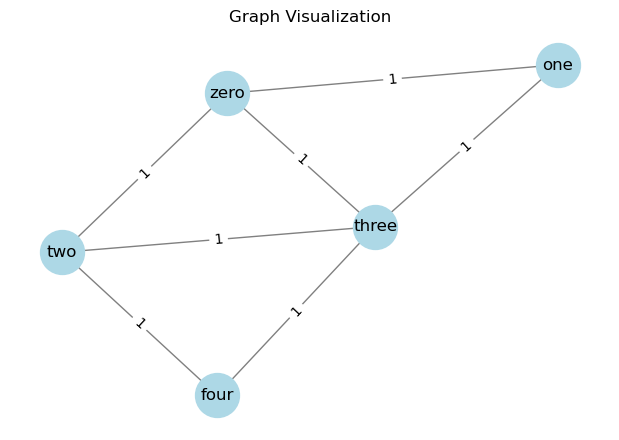

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Build a NetworkX graph
G = nx.Graph()

# Add nodes
for i, v in enumerate(V):
    G.add_node(i, label=v.data)

# Add edges with weights
for e in E:
    # find the integer index of the node in V
    a = V.index(e.A)
    b = V.index(e.B)
    G.add_edge(a, b, weight=e.w)

# Extract labels and edge weights
node_labels = {i: v.data for i, v in enumerate(V)}
edge_labels = {(V.index(e.A), V.index(e.B)): e.w for e in E}

# Layout for nice visualization
pos = nx.spring_layout(G, seed=42)

# Draw nodes & edges
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, labels=node_labels, 
        node_color="lightblue", node_size=1000, 
        font_size=12, edge_color="gray")

# Draw edge weights
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.axis("off")
plt.tight_layout()
plt.show()

## Adjacency Matrix
- Are two vertices connected?
- Encode it in an $n \times n$ **matrix** $A$
- The matrix elements:

$$
a_{ij} =
\begin{cases}
1 & \text{if $i$ and $j$ are connected} \\
0 & \text{otherwise}
\end{cases}
$$

- $A$ is a **symmetric matrix** (for undirected graphs)

### For example

- The previous case becomes 

>$ A = \left( \begin{array}{ccc}
0 & 1 & 1 & 1 & 0  \\
1 & 0 & 0 & 1 & 0  \\
1 & 0 & 0 & 1 & 1  \\
1 & 1 & 1 & 0 & 1  \\
0 & 0 & 1 & 1 & 0  \\
\end{array} \right)$

## Spectral Clustering
- How to cut the graph into pieces with minimal "damage"

### Graph Laplacian
- Degree matrix $D$ is diagonal matrix formed from the sum of all edges: $\displaystyle d_{ii} = \sum_j^n a_{ij} $
- The graph Laplacian: $ L = D - A$

#### An Interesting Property

- For any $x \in \mathbb{R}^n$, the bilinear expression $x^T L\,x $ has a familiar formula
    - $\displaystyle x^T L\,x = \sum_{i}^n d_{ii} x_i^2 - \sum_{i,j}^n  a_{ij}\,x_i x_j $
    - $\displaystyle \hspace{0.5in} = \frac{1}{2} \left\{ \sum_{i}^n d_{ii} x_i^2 - 2\sum_{i,j}^n  a_{ij}\,x_i x_j  + \sum_{j}^n d_{jj} x_j^2 \right\}$
    - $\displaystyle  \hspace{0.5in} = \frac{1}{2} \left\{ \sum_{i,j}^n a_{ij} x_i^2 - 2\sum_{i,j}^n  a_{ij}\,x_i x_j  + \sum_{i,j}^n a_{ij} x_j^2 \right\}$
    - $\displaystyle  \hspace{0.5in} = \frac{1}{2}\sum_{i,j}^n a_{ij}\,(x_i\!-\!x_j)^2 $
- Which is: $\displaystyle x^T L\,x = \frac{1}{2}\sum_{i,j}^n a_{ij}\,(x_i\!-\!x_j)^2 = $ $\displaystyle \frac{1}{2}\sum_{(i,j)\in{}E} (x_i\!-\!x_j)^2$

### Minimization
- Solution: the smallest eigenvalues of $L$ and corresponding eigenvectors
    - The 1st eigenvector is the trivial solution 
    - We use the 2nd eigenvector, and so on...
- Laplacian eigenmaps
    - Different similarity matrices to start with
    - Different normalizations

### Weighted Edges
- Instead of $A$ we can use a weight matrix $W$: $ L = D - W$ where $D$ has diagonal elements $\displaystyle d_{ii} = \sum_j w_{ij}$
- And the result is again $\displaystyle x^T L\,x = \frac{1}{2}\sum_{i,j}^n w_{ij}\,(x_i\!-\!x_j)^2 = $ $\displaystyle \frac{1}{2}\sum_{(i,j)\in{}E} w_{ij}\,(x_i\!-\!x_j)^2$

#### Variants
- Simple Laplacian: $ L = D-W$
- Normalized Laplacian: $ L_N = D^{-1/2}\,L\,D^{-1/2} = I -  D^{-1/2}\,W\,D^{-1/2}$
- Relaxed Laplacian: $ L_{\rho} = L - \rho D$
- Beltrami, etc...

## Manual Implementation
- Simulated dataset with blobs in 2-D
- Build the adjacency matrix based on a distance threshold: $d_{ij}=\sqrt{(x_i\!-\!x_j)^2 + (y_i\!-\!y_j)^2} < d_T$
- Calculate the $D$ degree matrix
- Calculate the $L$ graph Laplacian
- Solve the eigenproblem of $L$
- Study the eigenvalues and eigenvectors

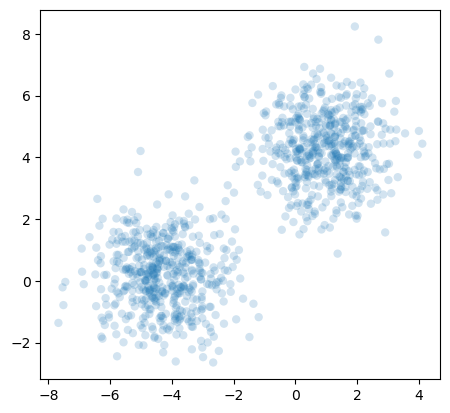

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
np.random.seed(3)
X,_ = datasets.make_blobs(n_samples=1000, centers=2, cluster_std=1.1)
X.shape
plt.subplot(aspect='equal'); 
plt.scatter(X[:,0], X[:,1], alpha=0.2, edgecolor='none')

Symmetric? True


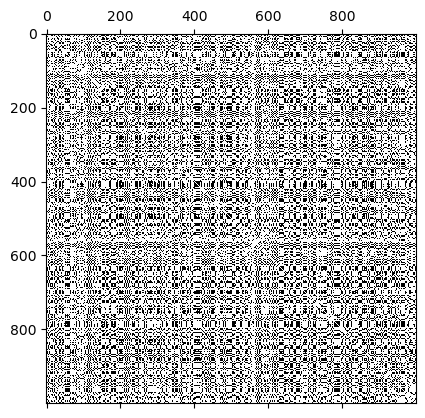

In [6]:
# Reshape data for broadcasting
m1 = X[np.newaxis, :, :]
m2 = X[:, np.newaxis, :]

# Pairwise distances
r = m1 - m2
r *= r 
d2 = r.sum(axis=-1)

# adjacency matrix
A = (d2<5)
np.fill_diagonal(A,False)
A = A.astype(np.float32)
print ('Symmetric?', np.allclose(A,A.T) )
plt.spy(A)

-8.587588e-14 0.70923734 (1000,) (1000, 1000)


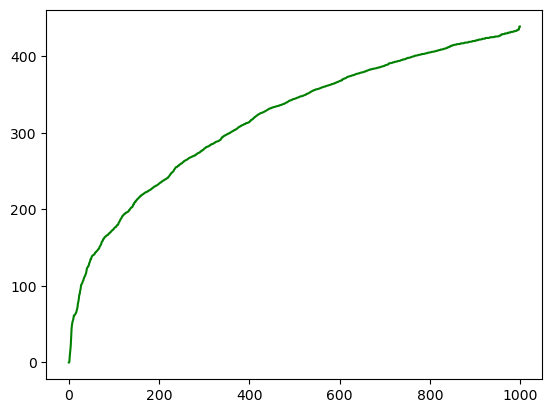

In [7]:
dd = A.sum(axis=0)
D = np.diag(dd)
L = D - A
w, v = np.linalg.eigh(L)
print (w[0], w[1], w.shape, v.shape)
plt.plot(w,'g')

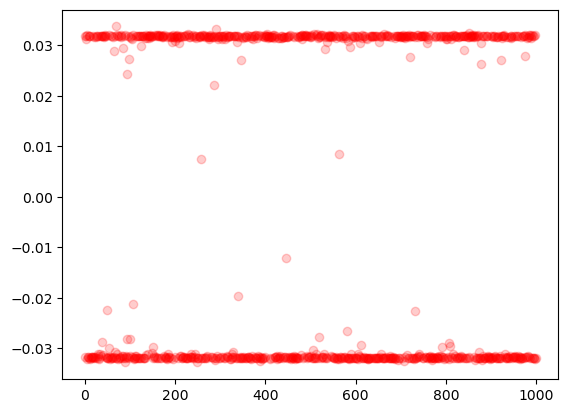

In [8]:
plt.plot(v[:,1], 'or', alpha=0.2)

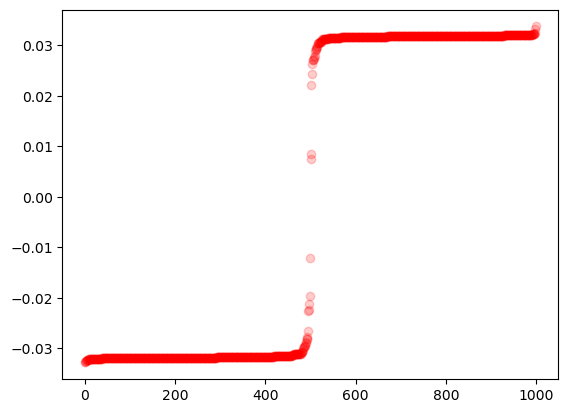

In [9]:
s = np.argsort(v[:,1])
plt.plot(v[s,1], 'ro', alpha=0.2);

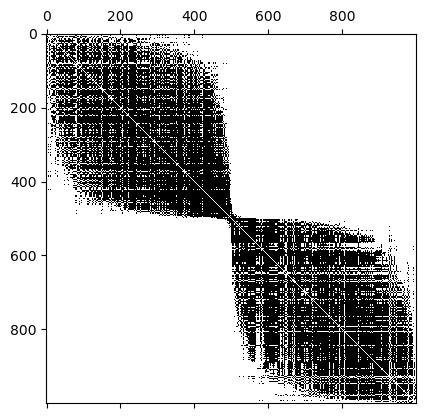

In [10]:
i,j = np.meshgrid(s,s)
# plt.figure(figsize=(8,8))
plt.spy(A[i,j]);

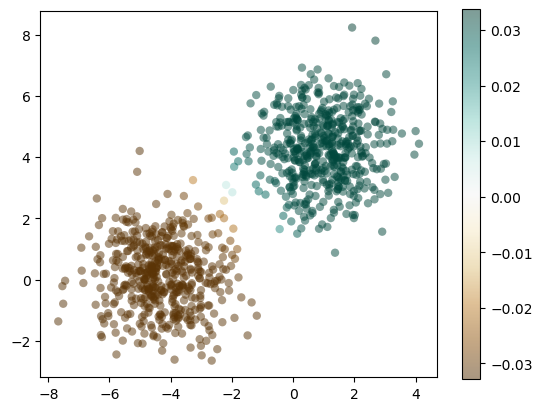

In [11]:
plt.subplot(aspect='equal')
plt.scatter(X[:,0], X[:,1], c=v[:,1], cmap=plt.cm.BrBG, alpha=0.5, edgecolor='none')
plt.colorbar();

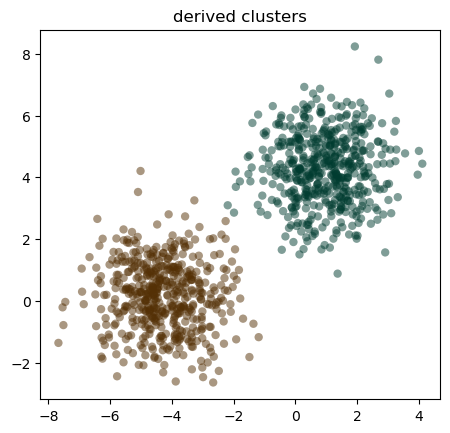

In [12]:
labels = (v[:,1] > 0)
plt.subplot(aspect='equal')
plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.BrBG, alpha=0.5, edgecolor='none'); 
plt.title('derived clusters');